# Stat 287 Final Report
### David W. Landay, MS Complex Systems and Data Science



In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [146]:
import json
import os
from datetime import datetime
from dateutil.parser import parse
import time
import newspaper
from newspaper import Article
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob as tb
from random import choice, sample
import string
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Data PreProcessing

In [3]:
#define path:
paths = [os.getcwd()+'\\GuardianUS_Trump_Tweets_2017-11-11_2017-12-11.json',
         os.getcwd()+'\\nytpolitics_Trump_Tweets_2017-11-11_2017-12-11.json',
         os.getcwd()+'\\foxnewspolitics_Trump_Tweets_2017-11-11_2017-12-11.json',
         os.getcwd()+'\\BreitbartNews_Trump_Tweets_2017-11-11_2017-12-11.json']

#get the tweets:
Gaurdian  = []
Nytimes   = []
FoxNews   = []
Breitbart = []

for i in range(len(paths)):
    if i == 0:
        with open(paths[i], 'r', encoding='utf-8') as f:
            for line in f:
                tweet = json.loads(line.strip())    
                Gaurdian.append(tweet)
    if i == 1:
        with open(paths[i], 'r', encoding='utf-8') as f:
            for line in f:
                tweet = json.loads(line.strip())    
                Nytimes.append(tweet)
    if i == 2:
        with open(paths[i], 'r', encoding='utf-8') as f:
            for line in f:
                tweet = json.loads(line.strip())    
                FoxNews.append(tweet)
    if i == 3:
        with open(paths[i], 'r', encoding='utf-8') as f:
            for line in f:
                tweet = json.loads(line.strip())    
                Breitbart.append(tweet)

In [4]:
#sanity check:
print('Gaurdian: '+Gaurdian[0]['full_text'],'\n')
print('NYTimes: '+Nytimes[0]['full_text'],'\n')
print('FoxNews: '+FoxNews[0]['full_text'],'\n')
print('Breitbart: '+Breitbart[1]['full_text'],'\n')

Gaurdian: Suspect arrested after attempted terrorist attack on New York subway – video report https://t.co/cuduNXpIWW 

NYTimes: Under President Trump, the EPA has ordered $1.2 billion of fixes to polluting facilities -- about 48 percent of what was sought under President Bush and about 12 percent of what was sought under President Obama. https://t.co/r52IJFmrgW 

FoxNews: Alabama Senate race: Obama, Biden record robo-calls for Jones - via @pdoocy 
https://t.co/3jRbfr7q75 

Breitbart: *pop* https://t.co/fpxRPjqNdj 



## Looks like links come at the end of the tweets. 
Assuming the structure holds for all tweets (for testing), let's split the text of the tweet and extract the URL. It will be used with the newspaper package to retrieve the articles that the tweets reference:

In [5]:
#extract URLs
url1 = Nytimes[0]['full_text'].split()[-1]
url2 = Gaurdian[0]['full_text'].split()[-1]
url3 = FoxNews[0]['full_text'].split()[-1]
url4 = Breitbart[1]['full_text'].split()[-1]

In [6]:
#now get the articles:
article1 = Article(url1)
article2 = Article(url2)
article3 = Article(url3)
article4 = Article(url4)

#download the articles:
article1.download()
article2.download()
article3.download()
article4.download()

#parse the articles:
article1.parse()
article2.parse()
article3.parse()
article4.parse()

In [7]:
#Print the article headlines:
print('Nytimes: '+article1.title,'\n')
print('Gaurdian: '+article2.title,'\n')
print('FoxNews: '+article3.title,'\n')
print('Breitbart: '+article4.title)

Nytimes: Under Trump, E.P.A. Has Slowed Actions Against Polluters, and Put Limits on Enforcement Officers 

Gaurdian: Suspect arrested after attempted terrorist attack on New York subway – video report 

FoxNews: Alabama Senate race: Obama, Biden record robo-calls for Jones 

Breitbart: Flabbergasted: Frank Luntz Shocked As Alabamians Back Roy Moore in Vice News Focus Group


## We can also  extract the articles themselves:

In [8]:
# as an example here is the nytimes article (only print the first 1000 characters):
article1.text[:1000]

'The E.P.A. moved in the final days of the Obama administration to resolve the S.H. Bell matter, proposing a consent decree in January that would require changes to reduce manganese dust levels and to improve monitoring.\n\nGenerally, a proposed consent decree is resolved within several months, but in March, the Trump administration asked a federal judge to delay the case so the E.P.A. could “brief incoming administration officials with decision-making responsibility” given that “many subordinate political positions at the agency remain unfilled.” The Justice Department has since asked the court to move ahead, but the case remains open.\n\nA spokeswoman for S.H. Bell said that the company had moved to comply with the requirements and that its operations had not harmed residents. The E.P.A. said in a statement that it was waiting for the court to act. “It would not be appropriate to discuss the open enforcement matters,” the statement said.\n\nRoberta Pratt, 49, a bartender who lives wi

## Looking further into the Nytimes article(s), we may notice that there are words we don't want to keep, including advertisements that newspaper.py couldn't rectify.
Some strings we want to replace in Nytimes articles may be:

* "Newsletter Sign Up Continue reading the main story Get the Morning Briefing by Email What you need to know to start your day, delivered to your inbox Monday through Friday. Please verify you're not a robot by clicking the box. Invalid email address. Please re-enter. You must select a newsletter to subscribe to. Sign Up You agree to receive occasional updates and special offers for The New York Times's products and services. Thank you for subscribing. An error has occurred. Please try again later. View all New York Times newsletters."
* "View all New York Times newsletters"
* "\n\nPhoto\n\n" $\rightarrow$ the word photo (denoting photos in the article) will mess us up.
* "Advertisement Continue reading the main story"
* "\n" $\rightarrow$ newline characters

In [9]:
#remove the unwanted text from the article:
ny1 = article1.text

#use .replace():
str2Remove = ["Newsletter Sign Up Continue reading the main story Get the Morning Briefing by Email What you need to know to start your day, delivered to your inbox Monday through Friday. Please verify you're not a robot by clicking the box. Invalid email address. Please re-enter. You must select a newsletter to subscribe to. Sign Up You agree to receive occasional updates and special offers for The New York Times's products and services. Thank you for subscribing. An error has occurred. Please try again later. View all New York Times newsletters.","View all New York Times newsletters","\n\nPhoto\n\n","Advertisement Continue reading the main story","\n"]
for string in str2Remove:
    if string in ny1:
        ny1 = ny1.replace(string, "")

In [10]:
#sanity check:
ny1[:1000]

'The E.P.A. moved in the final days of the Obama administration to resolve the S.H. Bell matter, proposing a consent decree in January that would require changes to reduce manganese dust levels and to improve monitoring.Generally, a proposed consent decree is resolved within several months, but in March, the Trump administration asked a federal judge to delay the case so the E.P.A. could “brief incoming administration officials with decision-making responsibility” given that “many subordinate political positions at the agency remain unfilled.” The Justice Department has since asked the court to move ahead, but the case remains open.A spokeswoman for S.H. Bell said that the company had moved to comply with the requirements and that its operations had not harmed residents. The E.P.A. said in a statement that it was waiting for the court to act. “It would not be appropriate to discuss the open enforcement matters,” the statement said.Roberta Pratt, 49, a bartender who lives with her famil

## What about the other newsoutlets?

In [11]:
g1 = article2.text

In [12]:
g1

'Four people were reported to have been injured in an explosion in the Manhattan area of the city on Monday. The incident happened at around 7.20am local time in a passageway between the 42nd Street Times Square station and the New York Port Authority'

##### seems likely that this was a link to a video:

In [13]:
url_2 = Gaurdian[2]['full_text'].split()[-1]

In [14]:
url_2

'https://t.co/VNlIVP4ycv'

In [15]:
art_2 = Article(url_2)
art_2.download()
art_2.parse()

art_2.title

"An alleged sexual predator, Republican civil war and Steve Bannon: what's at stake in Alabama?"

In [16]:
g2 = art_2.text

##### For the Guardian, it looks like the main issues are:
* \n\nFacebook Twitter Pinterest
* "\n"
* some photos that we could extract with regex

In [17]:
#like before, remove blemishes:
str2Remove = ["\n\nFacebook Twitter Pinterest\n","\n"]
for string in str2Remove:
    if string in g2:
        g2 = g2.replace(string, "")

In [18]:
f1 = article3.text

f1

'Former President Barack Obama and his veep Joe Biden have recorded robo-calls in support of Democratic Alabama Senate candidate Doug Jones, in a final push to get out the vote ahead of Tuesday’s special election.\n\nA Jones campaign official confirmed the calls to Fox News. They started going out statewide on Monday.\n\nThe 11th-hour efforts are being undertaken on both sides. President Trump – who held a rally Friday just across the Alabama state line in Florida where he touted Republican Roy Moore’s candidacy – has also recorded a pro-Moore robo-call.\n\nThe national interest reflects the importance to Trump\'s agenda of keeping the seat in Republican hands.\n\nMoore has been dogged by allegations for weeks that he pursued and even molested teenage women when he was a young prosecutor.\n\nMoore denies the allegations.\n\n“These allegations are completely false. I did not date underaged women. I did not molest anyone. And so these allegations are false,” Moore said during an intervie

##### At Fox, a couple of problems I encountered were:
* "advertisement"
* "\n"

In [19]:
str2Remove = ["advertisement","\n"]

for string in str2Remove:
    if string in f1:
        f1 = f1.replace(string,"")
f1

'Former President Barack Obama and his veep Joe Biden have recorded robo-calls in support of Democratic Alabama Senate candidate Doug Jones, in a final push to get out the vote ahead of Tuesday’s special election.A Jones campaign official confirmed the calls to Fox News. They started going out statewide on Monday.The 11th-hour efforts are being undertaken on both sides. President Trump – who held a rally Friday just across the Alabama state line in Florida where he touted Republican Roy Moore’s candidacy – has also recorded a pro-Moore robo-call.The national interest reflects the importance to Trump\'s agenda of keeping the seat in Republican hands.Moore has been dogged by allegations for weeks that he pursued and even molested teenage women when he was a young prosecutor.Moore denies the allegations.“These allegations are completely false. I did not date underaged women. I did not molest anyone. And so these allegations are false,” Moore said during an interview with The Voice of Alab

In [20]:
b1 = article4.text

b1[:1000]

'MONTGOMERY, Alabama — Frank Luntz, a GOP establishment messaging consultant, was visibly flabbergasted as every single one of his focus group participants in a Birmingham area Vice News-produced panel backed Judge Roy Moore for U.S. Senate.\n\nTitled “Why These Alabama Voters Are Sticking By Roy Moore,” Luntz’s Vice News focus group aired on Vice News Tonight on Dec. 8 on HBO.\n\nadvertisement\n\n“Are you all Christians here?” Luntz opens the seven-and-a-half-minute long segment. “Yes,” all of the focus group participants, who joined Luntz in a Birmingham area restaurant, replied.\n\n“Is Roy Moore a good Christian?” he followed up.\n\n“Yes,” one woman replied. “Absolutely,” another said.\n\n“Absolutely?” Luntz followed up in disbelief. “Yes,” the woman shot back. “Without any doubt whatsoever?” Luntz asked again.\n\nAfter some more back and forth, a man in the focus group spoke up. Scottie Porter, a real estate developer, said:\n\nHe’s not my choice, I’m not voting for him because I l

##### For Breitbart, I encountered:
* "advertisement"
* "\n"

In [21]:
str2Remove = ["advertisement","\n"]

for string in str2Remove:
    if string in b1:
        b1 = b1.replace(string,"")
        
b1[:1000]

'MONTGOMERY, Alabama — Frank Luntz, a GOP establishment messaging consultant, was visibly flabbergasted as every single one of his focus group participants in a Birmingham area Vice News-produced panel backed Judge Roy Moore for U.S. Senate.Titled “Why These Alabama Voters Are Sticking By Roy Moore,” Luntz’s Vice News focus group aired on Vice News Tonight on Dec. 8 on HBO.“Are you all Christians here?” Luntz opens the seven-and-a-half-minute long segment. “Yes,” all of the focus group participants, who joined Luntz in a Birmingham area restaurant, replied.“Is Roy Moore a good Christian?” he followed up.“Yes,” one woman replied. “Absolutely,” another said.“Absolutely?” Luntz followed up in disbelief. “Yes,” the woman shot back. “Without any doubt whatsoever?” Luntz asked again.After some more back and forth, a man in the focus group spoke up. Scottie Porter, a real estate developer, said:He’s not my choice, I’m not voting for him because I like him. I’m voting for him because I don’t w

## Now I want to handle dates:
Eventually, I would like to perform some timeseries analysis.

In [22]:
Nytimes[0]["created_at"]

'Mon Dec 11 16:35:03 +0000 2017'

From previous work, we know the format of these date-time strings. We would like to go through all tweets in a list and convert the strings to date-time objects.

In [23]:
#first, we don't need the +000
#Turn the string into a datetime.datetime object:
t = datetime.strptime(Nytimes[0]["created_at"],'%a %b %d %X %z %Y')

#Print the result for confirmation:
print(t)

2017-12-11 16:35:03+00:00


Now we want to truncate it to the hour, eliminating the utc offset:

In [24]:
#what values are in our specific fields?
parse(Nytimes[0]["created_at"])

datetime.datetime(2017, 12, 11, 16, 35, 3, tzinfo=tzutc())

ok, so we can fix it thusly:

In [25]:
t = t.replace(minute=0,second= 0, tzinfo=None)

In [26]:
print(t)

2017-12-11 16:00:00


We will want to iterate through each list of tweets and fix the datetimes

## Any other information we should extract besides tweets, dates, and urls leading to related articles?

* We will keep the retweet count `retweet_count`: number of times a twitter post was retweeted. Perhaps it can tell us something about the popularity of the newsoutlet over time. Perhaps we can gleam other useful information from it.

## Build a list of tuples containing all the information we wish to keep:
* (text, date, retweet_count, url)

In [27]:
#create a list of all news outlets:
Outlets = [Gaurdian, Nytimes, FoxNews, Breitbart]

#create new lists to store the tuples:
gaurd = []
nyt   = []
fox   = []
breit = []

extracted = [gaurd, nyt, fox, breit]

#Iterate over the list of lists:
for idx, agency in enumerate(Outlets):
    for i in range(len(agency)):
        if "https://" in agency[i]['full_text'] or "http://" in agency[i]['full_text']: #ensure the presence of a url:
            extracted[idx].append([agency[i]['full_text'],agency[i]['created_at'],agency[i]['retweet_count'], 
                                   agency[i]['full_text'].split()[-1]])
        else:
            extracted[idx].append([agency[i]['full_text'],agency[i]['created_at'],agency[i]['retweet_count'], 
                                   "Null"])
            
    
    

In [28]:
#sanity check:
print(gaurd[0],"\n")
print(nyt[0],"\n")
print(fox[0],"\n")
print(breit[0],"\n")

['Suspect arrested after attempted terrorist attack on New York subway – video report https://t.co/cuduNXpIWW', 'Mon Dec 11 16:27:52 +0000 2017', 6, 'https://t.co/cuduNXpIWW'] 

['Under President Trump, the EPA has ordered $1.2 billion of fixes to polluting facilities -- about 48 percent of what was sought under President Bush and about 12 percent of what was sought under President Obama. https://t.co/r52IJFmrgW', 'Mon Dec 11 16:35:03 +0000 2017', 4, 'https://t.co/r52IJFmrgW'] 

['Alabama Senate race: Obama, Biden record robo-calls for Jones - via @pdoocy \nhttps://t.co/3jRbfr7q75', 'Mon Dec 11 16:19:43 +0000 2017', 15, 'https://t.co/3jRbfr7q75'] 

['RT @AdelleNaz: ISIS-inspired suicide bomber failed to properly detonate himself in #NYC. Suspect is originally from Bangladesh. He moved to…', 'Mon Dec 11 16:40:08 +0000 2017', 210, 'Null'] 



#### Now clean the tuples

In [29]:
import string

In [30]:
punct = str.maketrans(dict.fromkeys(string.punctuation)) # a dict of punctuation we wish to remove
remove_digits = str.maketrans(dict.fromkeys(string.digits))# a dict of digits we want to remove

for agency in extracted:
    for tup in agency:
        tup[0] = tup[0].replace(tup[3],"")# gets rid of url from the  tweet
        tup[0] = tup[0].translate(punct)# gets rid of punctuation
        tup[0] = tup[0].translate(remove_digits)# gets rid of digits
        tup[0] = tup[0].replace('RT',"")
        tup[1] = datetime.strptime(tup[1],'%a %b %d %X %z %Y').replace(minute=0,second= 0, tzinfo=None)#creates datetime obj

Turn them into tuples:

In [31]:
for i in range(len(extracted)):
    extracted[i] = [tuple(l) for l in extracted[i]]

In [183]:
gaurd = extracted[0]
nyt   = extracted[1]
fox   = extracted[2]
breit = extracted[3]

#sanity check:
print(gaurd[0],"\n")
print(nyt[0],"\n")
print(fox[0],"\n")
print(breit[0])

('Suspect arrested after attempted terrorist attack on New York subway – video report ', datetime.datetime(2017, 12, 11, 16, 0), 6, 'https://t.co/cuduNXpIWW') 

('Under President Trump the EPA has ordered  billion of fixes to polluting facilities  about  percent of what was sought under President Bush and about  percent of what was sought under President Obama ', datetime.datetime(2017, 12, 11, 16, 0), 4, 'https://t.co/r52IJFmrgW') 

('Alabama Senate race Obama Biden record robocalls for Jones  via pdoocy \n', datetime.datetime(2017, 12, 11, 16, 0), 15, 'https://t.co/3jRbfr7q75') 

(' AdelleNaz ISISinspired suicide bomber failed to properly detonate himself in NYC Suspect is originally from Bangladesh He moved to…', datetime.datetime(2017, 12, 11, 16, 0), 210, 'Null')


***
## Perform Analysis:

#### Road Map:
* Data Cleaning *complete*
* Word Selection
* Probability building
* Disagreement scores
* Find Extremes <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;We will want to first find keywords in each corpera by scoring the importance of each word in a document. The mean score for each word accross documents will represent the score for that word accross the entire corpera, and the highest scores will be selected as the keywords to use for analysis. I will then build a set of all unique keywords accross corpera. Next, we will consider each of the keywords to be an arbitrary "world state" and consider each news outlet to be some "agency" that uses each word. The "assessment" will be a bayesian probability considering the likelihood of that word, given that a particular agency uses it. Hence, each "agency" now has a probability associated with each "world state". The disagreement between agencies can now be computed using the Bhatacharyya distance formula. The probabilities describe discrete distributions , hence we will use the formula given by:<br><br> $$D_B (p,q) = -ln(BC(p,q))$$ $$\text{where}$$  $$p, q$$ $$\text{are two distinct agencies, and}$$ $$BC(p,q) = \sum_{x\in X} \sqrt{pq}$$

***
### Word Selection:

In [33]:
#build strictly the word corpera:
gaurd_docs = []
nyt_docs   = []
fox_docs   = []
breit_docs = []

corps = [gaurd_docs, nyt_docs, fox_docs, breit_docs]
#loop over the full_text of each tweet
for idx, agency in enumerate(extracted):
    for i in range(len(agency)):
        corps[idx].append(agency[i][0].lower()) #lowercase further cleans the tweets

Ok, now we have our corpera containing just the text portion of the tweets, we want to tokenize each document in the corpera so we can prepare them for analysis. The nltk (natural language tool-kit)  package provides a hassle free solution. An alternative to nltk's functionality is to call .split() function on each document (they both do the same thing, but I am trying to learn the nltk package):

In [34]:
#here is an example of tokenizing:
example = word_tokenize(nyt_docs[0])
print(example)

['under', 'president', 'trump', 'the', 'epa', 'has', 'ordered', 'billion', 'of', 'fixes', 'to', 'polluting', 'facilities', 'about', 'percent', 'of', 'what', 'was', 'sought', 'under', 'president', 'bush', 'and', 'about', 'percent', 'of', 'what', 'was', 'sought', 'under', 'president', 'obama']


In [35]:
#Here is an example of tf-idf:
def wordSet(corpus):
    """WORDSET creates a set of unique words in the corpus"""
    
    #loop through the collection, add each word to the set:
    set_of_words = set()
    for document in corpus:
        set_of_words.add(document)
    
    return set_of_words
        
        

In [36]:
example_set = wordSet(example)

#sanity check:
print(example_set)

{'fixes', 'and', 'epa', 'of', 'to', 'bush', 'what', 'about', 'president', 'trump', 'has', 'facilities', 'ordered', 'polluting', 'the', 'sought', 'percent', 'obama', 'billion', 'was', 'under'}


In [37]:
def wordDict(set_of_words, document):
    """WORDDICT takes the unique set of words for a collection of documents and initializes a dictionary 
    of relative frequencies for each document"""
    word_dict = dict.fromkeys(set_of_words,0)
    
    #populate the dictionary with the relative frequencies of words in each document:
    for word in document:
        word_dict[word] += 1
    return word_dict

In [38]:
example_dict = wordDict(example_set, example)

#sanity check:
print(example_dict)

{'fixes': 1, 'and': 1, 'epa': 1, 'of': 3, 'to': 1, 'bush': 1, 'what': 2, 'about': 2, 'president': 3, 'trump': 1, 'has': 1, 'facilities': 1, 'ordered': 1, 'polluting': 1, 'the': 1, 'sought': 2, 'percent': 2, 'obama': 1, 'billion': 1, 'was': 2, 'under': 3}


In [39]:
def tf(word_dict, document):
    """TF computes the 'Term Frequency'--> it re-initializes the word dictionary with the relative 
    frequencies of each word in a document (now a bag-of-words)"""
    
    #initialize an empty dictionary to store frequencies:
    TFdict = {}
    
    #consider the length of each 
    b_o_w_count = len(document)
    
    #loop through the document and populate the frequency dictionary:
    for word, count in word_dict.items():
        TFdict[word] = count / float(b_o_w_count) #number of instances of a word/total number of words in the bow
    
    return TFdict

In [40]:
example_TF = tf(example_dict, example)

#sanity check:
print(example_TF)

{'fixes': 0.03125, 'and': 0.03125, 'epa': 0.03125, 'of': 0.09375, 'to': 0.03125, 'bush': 0.03125, 'what': 0.0625, 'about': 0.0625, 'president': 0.09375, 'trump': 0.03125, 'has': 0.03125, 'facilities': 0.03125, 'ordered': 0.03125, 'polluting': 0.03125, 'the': 0.03125, 'sought': 0.0625, 'percent': 0.0625, 'obama': 0.03125, 'billion': 0.03125, 'was': 0.0625, 'under': 0.09375}


In [41]:
def idf(list_of_documents):
    """IDF computes the 'Inverse Document Frequency': takes the number of documents in the collection
    and divides it by the number of documents containing a word"""
    
    #define the total number of documents:
    n_documents = len(list_of_documents)
    
    #create another empty dictionary:
    idfDict = {}
    
    idfDict = dict.fromkeys(list_of_documents[0], 0) #initialize it:
    
    #populate it:
    for doc in list_of_documents:
        for word, count in doc.items(): #if the word is present in the document, then add it's count to idfDict[word]
            if count > 0:
                idfDict[word] += 1
    
    #compute the idf: log(n_documents / idfDict[word]):
    for word, count in idfDict.items():
        idfDict[word] = math.log(n_documents / float(count))
    
    return idfDict

In [42]:
doc_list = [example_dict]
example_idf = idf(doc_list)

In [43]:
#sanity check:
print(example_idf)

{'fixes': 0.0, 'and': 0.0, 'epa': 0.0, 'of': 0.0, 'to': 0.0, 'bush': 0.0, 'what': 0.0, 'about': 0.0, 'president': 0.0, 'trump': 0.0, 'has': 0.0, 'facilities': 0.0, 'ordered': 0.0, 'polluting': 0.0, 'the': 0.0, 'sought': 0.0, 'percent': 0.0, 'obama': 0.0, 'billion': 0.0, 'was': 0.0, 'under': 0.0}


Notice that for the example, we have a corpus containing 1 document. Hence, the outcome of the idf will be zero!

In [44]:
def tf_idf(tf_bow, idfs):
    """TF_IDF calculates the 'Term Frequency - Inverse Document Frequncy' given a set of tfs and idfs"""
    
    #initialize a dictionary to store values:
    tfidf = {}
    
    #populate it with the sentiment scores:
    for word, count in tf_bow.items():
        tfidf[word] = tf_bow[word] * idfs[word]
    
    return tfidf

In [45]:
example_tfidf = tf_idf(example_TF, example_idf)

In [46]:
#sanity check:
print(example_tfidf)

{'fixes': 0.0, 'and': 0.0, 'epa': 0.0, 'of': 0.0, 'to': 0.0, 'bush': 0.0, 'what': 0.0, 'about': 0.0, 'president': 0.0, 'trump': 0.0, 'has': 0.0, 'facilities': 0.0, 'ordered': 0.0, 'polluting': 0.0, 'the': 0.0, 'sought': 0.0, 'percent': 0.0, 'obama': 0.0, 'billion': 0.0, 'was': 0.0, 'under': 0.0}


Now let's do this word selection process for each news agency:

In [47]:
#create a list of stop words to remove (nltk provides a list for most languages):
stopWords = set(stopwords.words('english'))

#start with The Gaurdian: Tokenize!
gaurd_tokenized = []
for doc in gaurd_docs:
    gaurd_tokenized.append(word_tokenize(doc))

#filter stop words:
gaurd_filtered = []
for doc in gaurd_tokenized:
    filtered = []
    for word in doc:
        if word not in stopWords:
            filtered.append(word)
    gaurd_filtered.append(filtered)
    

#next, create the set of unique words for The Gaurdian:
gaurd_unique = set()
for set_ in gaurd_filtered:
    gaurd_unique = gaurd_unique.union(set_)

#next, create the wordDicts for each document:
gaurd_dicts = []

for bow in gaurd_filtered:
    gaurd_dicts.append(wordDict(gaurd_unique,bow))

In [48]:
#next, get term frequencies:
gaurd_tf = []

for i in range(len(gaurd_filtered)):
    gaurd_tf.append(tf(gaurd_dicts[i], gaurd_filtered[i]))

In [49]:
#next, get the inverse document frequencies:
gaurd_idf = idf(gaurd_dicts)

In [50]:
#finally, compute the tfidf of the Gaurdian:
gaurd_tfidf = []

for tf_count in gaurd_tf:
    gaurd_tfidf.append(tf_idf(tf_count, gaurd_idf))

In [51]:
def sortByValue(dictionary):
    """SORTBYVALUE takes a dictionary and returns it sorted by value"""
    sorted_dict = sorted(dictionary.items(), key = lambda t:t[1], reverse = True)
    return sorted_dict

#sanity check, order the dictionaries from greatest to least key values: 
sortByValue(gaurd_tfidf[0])[:11]

[('attempted', 0.7346795491033684),
 ('terrorist', 0.6716661690524642),
 ('subway', 0.5883670116093592),
 ('arrested', 0.5717923246280907),
 ('suspect', 0.545639408950656),
 ('report', 0.4254797871340816),
 ('video', 0.4196126488488478),
 ('york', 0.3906623096562537),
 ('attack', 0.37204463577934344),
 ('new', 0.28609100972785095),
 ('–', 0.20110710245484345)]

Now we want to select the words from all tf_idf dictionaries with the highest scores:

In [52]:
#create a place to hold the most meaningful words:
gaurd_words = []

#if for any dictionary, the scores are greater than 0, then append gaurd_words:
for scores in gaurd_tfidf:
    for word, count in scores.items():
        if count > 0:
            gaurd_words.append((word,count))

#turn the list into a set:
gaurd_words = set(gaurd_words)

In [53]:
gaurd_words = list(gaurd_words)

#sort the list in reverse order so we can see the highest values:
gaurd_words.sort(key=lambda x: x[1], reverse = True)

In [54]:
#Note* these were the highest scores amongst individual documents:
gaurd_words[:10]

[('paradisepapers', 6.472037127702952),
 ('kayaktivist', 4.040737520068526),
 ('tracks', 4.040737520068526),
 ('photograph', 3.6941639297885533),
 ('inequality', 3.3475903395085806),
 ('experience', 2.9421252314004165),
 ('americanos', 2.6938250133790174),
 ('tuesdays', 2.6938250133790174),
 ('novotná', 2.6938250133790174),
 ('kapoor', 2.6938250133790174)]

Hmmm... Gaurdian U.S was tricky to parse. We managed to get some expected words, like 'inequality' and 'experience'; words that are typical amongst periodicals. Despite being the handle which represents U.S politics, they intermingle tweets about sporting events with those about U.S politics. <br><br>
For instance, many tweets about MLS games were mentioned and you will notice that Jana Novotná, former professional tennis player from the Czech Republic, was mentioned on account of her recent death.<br><br>
I suspect that this noise could be a result of a bad query search through the twitter API. Perhaps I was not detailed enough while setting search parameters. Just by glimpsing at some of the tweets scraped from other outlets, I noticed far fewer (if at all) tweets that either did not mention "Trump" (as was the query search parameter), or post a url with an article that mentioned "Trump", or strictly American politics in some fashion.<br><br>
Mentioning this may be jumping the gun, as we haven't yet answered a question difinitively about word disagreement, but perhaps because The Gaurdian is a foreign news outlet, their U.S handle tweets out a general set of U.S news in addition to news about politics.

In [55]:
#let's now carry out the same process for the other news outlets:

#tokenize!
nyt_tokenized = []
for doc in nyt_docs:
    nyt_tokenized.append(word_tokenize(doc))

#filter stop words:
nyt_filtered = []
for doc in nyt_tokenized:
    filtered = []
    for word in doc:
        if word not in stopWords:
            filtered.append(word)
    nyt_filtered.append(filtered)

#next, create the set of unique words for NewYorkTimes:
nyt_unique = set()
for set_ in nyt_filtered:
    nyt_unique = nyt_unique.union(set_)

#next, create the wordDicts for each document:
nyt_dicts = []

for bow in nyt_filtered:
    nyt_dicts.append(wordDict(nyt_unique,bow))

In [56]:
#next, get term frequencies:
nyt_tf = []

for i in range(len(nyt_filtered)):
    nyt_tf.append(tf(nyt_dicts[i], nyt_filtered[i]))

In [57]:
#next, get the inverse document frequencies:
nyt_idf = idf(nyt_dicts)

In [58]:
#finally, compute the tfidf of the NewYorkTimes:
nyt_tfidf = []

for tf_count in nyt_tf:
    nyt_tfidf.append(tf_idf(tf_count, nyt_idf))

In [59]:
#sanity check, order the dictionaries from greatest to least key values: 
sortByValue(nyt_tfidf[0])[:11]

[('percent', 0.8083846768897786),
 ('sought', 0.6796822497421338),
 ('polluting', 0.5047822079720206),
 ('facilities', 0.5047822079720206),
 ('fixes', 0.5047822079720206),
 ('ordered', 0.38316282365606347),
 ('bush', 0.3494755423602705),
 ('president', 0.3292025687440774),
 ('billion', 0.32770637396850705),
 ('epa', 0.3144995556143066),
 ('obama', 0.2615434393401064)]

In [60]:
#create a place to hold the most meaningful words:
nyt_words = []

#if for any dictionary, the scores are greater than 0, then append nyt_words:
for scores in nyt_tfidf:
    for word, count in scores.items():
        if count > 0:
            nyt_words.append((word,count))

#turn the list into a set:
nyt_words = set(nyt_words)

In [61]:
nyt_words = list(nyt_words)

#sort the list in reverse order so we can see the highest values:
nyt_words.sort(key=lambda x: x[1], reverse = True)

In [62]:
#Note* these were the highest scores amongst individual documents:
nyt_words[:10]

[('tossup', 2.692171775850776),
 ('art', 2.325967679628073),
 ('hallway', 2.2300736554774794),
 ('papadopoulos', 2.2046263880363166),
 ('mean', 2.155692471706076),
 ('faster', 2.0191288318880822),
 ('zzzs', 2.0191288318880822),
 ('snooze', 2.0191288318880822),
 ('exposures', 2.0191288318880822),
 ('mediator', 2.0191288318880822)]

*Note* These are only the first ten words, but looking through the rest of the list we see far more words referrencing "Trump" than The Gaurdian U.S does. In addition, the words in the list seem to reflect negatively toward conservative views (our expectation). A positive sign is that there are words in this list which also exist in The Gaurdian U.S's list of words. For example, the word "terrorist" appears in both. Crossover indicates promise!

In [63]:
# Continue on, gather the words of interest for fox news:

#tokenize!
fox_tokenized = []
for doc in fox_docs:
    fox_tokenized.append(word_tokenize(doc))

#filter stop words:
fox_filtered = []
for doc in fox_tokenized:
    filtered = []
    for word in doc:
        if word not in stopWords:
            filtered.append(word)
    fox_filtered.append(filtered)

#next, find the set of unique words for FoxNews:
fox_unique = set()
for set_ in fox_filtered:
    fox_unique = fox_unique.union(set_)

#next, create the wordDicts for each document:
fox_dicts = []

for bow in fox_filtered:
    fox_dicts.append(wordDict(fox_unique,bow))

In [64]:
#throwing an error in the next step has made me halt the process:
for i in range(len(fox_filtered)):    
    if len(fox_filtered[i]) == 0:
        print(i)

250
367


We will throw an error if we try to compute the term frequency for these documents.<br><br>
Since @foxnewspolitics tweets many articles, it is possible that for these two instances @foxnewpolitics only tweeted an article or cleaning of the text has eliminated any words from the filtered list.<br><br>
Let's fix this now:

In [65]:
#remove the items at index 250 and 367:
del fox_filtered[367] #deleting the higher index will not re-assign index 250
del fox_filtered[250]

#carry on!

#next, find the set of unique words for FoxNews:
fox_unique = set()
for set_ in fox_filtered:
    fox_unique = fox_unique.union(set_)

#next, create the wordDicts for each document:
fox_dicts = []

for bow in fox_filtered:
    fox_dicts.append(wordDict(fox_unique,bow))

In [66]:
#next, get term frequencies:
fox_tf = []

for i in range(len(fox_filtered)):
    fox_tf.append(tf(fox_dicts[i], fox_filtered[i]))

Nice! no errors. Proceed!

In [67]:
#next, get the inverse document frequencies:
fox_idf = idf(fox_dicts)

In [68]:
#finally, compute the tfidf of the FoxNewsPolitics:
fox_tfidf = []

for tf_count in fox_tf:
    fox_tfidf.append(tf_idf(tf_count, fox_idf))

In [69]:
#create a place to hold the most meaningful words:
fox_words = []

#if for any dictionary, the scores are greater than 0, then append nyt_words:
for scores in fox_tfidf:
    for word, count in scores.items():
        if count > 0:
            fox_words.append((word,count))

#turn the list into a set:
fox_words = set(fox_words)

In [70]:
fox_words = list(fox_words)

#sort the list in reverse order so we can see the highest values:
fox_words.sort(key=lambda x: x[1], reverse = True)

In [71]:
#Note* these were the highest scores amongst individual documents:
fox_words[:10]

[('httpstcosimfucla', 4.041818601570774),
 ('httpstcotfjaneziix', 3.695245011290801),
 ('moab', 3.2370996453537235),
 ('amendment', 3.068863527043117),
 ('th', 2.759343922840005),
 ('seriously', 2.696519028820068),
 ('believe', 2.619384342927539),
 ('exclusive', 2.543952464793778),
 ('china', 2.183343876895168),
 ('neil', 2.1580664302358157)]

Ok, so we may need to clean the shitty links that were, for some reason, never dispunged from the data.<br><br>
I say this from pure observation, but holy moly! "believe" and, although not shown, "bible" are both in the list of key words. Again, I don't want to speculate, but results seem promising. Oh! Also, the word (or mispelling of a word) "th" appears in the corpus.<br><br>
Let's try to clean up the FoxNews keywords by eliminating those pesky urls:

In [72]:
#delete indices in which the string contains 'http' or 'https'
for doc in fox_filtered:
    for idx, word in enumerate(doc):
        if 'http' in word or 'https' in word:
            del doc[idx]

In [73]:
#next, find the set of unique words for FoxNews:
fox_unique = set()
for set_ in fox_filtered:
    fox_unique = fox_unique.union(set_)

#next, create the wordDicts for each document:
fox_dicts = []

for bow in fox_filtered:
    fox_dicts.append(wordDict(fox_unique,bow))

In [74]:
#next, get term frequencies:
fox_tf = []

for i in range(len(fox_filtered)):
    fox_tf.append(tf(fox_dicts[i], fox_filtered[i]))

In [75]:
#next, get the inverse document frequencies:
fox_idf = idf(fox_dicts)

In [76]:
#finally, compute the tfidf of the FoxNewsPolitics:
fox_tfidf = []

for tf_count in fox_tf:
    fox_tfidf.append(tf_idf(tf_count, fox_idf))

In [77]:
#create a place to hold the most meaningful words:
fox_words = []

#if for any dictionary, the scores are greater than 0, then append nyt_words:
for scores in fox_tfidf:
    for word, count in scores.items():
        if count > 0:
            fox_words.append((word,count))

#turn the list into a set:
fox_words = set(fox_words)

In [78]:
fox_words = list(fox_words)

#sort the list in reverse order so we can see the highest values:
fox_words.sort(key=lambda x: x[1], reverse = True)

In [79]:
#Note* these were the highest scores amongst individual documents:
fox_words[:10]

[('moab', 6.474199290707447),
 ('exclusive', 5.087904929587556),
 ('amendment', 3.068863527043117),
 ('th', 2.759343922840005),
 ('seriously', 2.696519028820068),
 ('believe', 2.619384342927539),
 ('china', 2.183343876895168),
 ('neil', 2.1580664302358157),
 ('halftime', 2.0852492213118534),
 ('vol', 2.020909300785387)]

Noice! Cleaning is never over!!!

***
Before beginning on extracting words from the @BreitbartNews corpus, it is worth mentioning that the average length of their tweets is shorter in comparison to the tweets published by other outlets. One work around is to apply Maximum normalized tf where term frequency is drawn with consideration to varying lengths of the documents. Otherwise, lack of words in the corpus could bias the disagreement measure. This will be important when analyzing news articles.

In [80]:
# Continue on, gather the words of interest for Breitbart:

#tokenize!
breit_tokenized = []
for doc in breit_docs:
    breit_tokenized.append(word_tokenize(doc))

#filter stop words:
breit_filtered = []
for doc in breit_tokenized:
    filtered = []
    for word in doc:
        if word not in stopWords:
            filtered.append(word)
    breit_filtered.append(filtered)

#next, find the set of unique words for Breitbart:
breit_unique = set()
for set_ in breit_filtered:
    breit_unique = breit_unique.union(set_)

#next, create the wordDicts for each document:
breit_dicts = []

for bow in breit_filtered:
    breit_dicts.append(wordDict(breit_unique,bow))

In [81]:
#throwing an error in the next step has made me halt the process:
count = 0
idx_2_delete = []
for i in range(len(breit_filtered)):    
    if len(breit_filtered[i]) == 0:
        count+=1
        idx_2_delete.append(i)
print(count)

117


In [82]:
#the total tweet count is over 3200. With this many samples, we should be able to safely throw out these empty documents.
#in addition, as we have dispunged stop words, it is approprate to eliminate these empty documents.
idx_2_delete = sorted(idx_2_delete, reverse = True)
print(idx_2_delete[:10])

[3142, 2933, 2870, 2860, 2834, 2800, 2788, 2676, 2659, 2556]


In [83]:
for idx, item in enumerate(idx_2_delete):
    del breit_filtered[item]

In [84]:
#next, find the set of unique words for Breitbart:
breit_unique = set()
for set_ in breit_filtered:
    breit_unique = breit_unique.union(set_)

#next, create the wordDicts for each document:
breit_dicts = []

for bow in breit_filtered:
    breit_dicts.append(wordDict(breit_unique,bow))

In [85]:
#next, get term frequencies:
breit_tf = []

for i in range(len(breit_filtered)):
    breit_tf.append(tf(breit_dicts[i], breit_filtered[i]))

In [86]:
#next, get the inverse document frequencies:
breit_idf = idf(breit_dicts)

In [87]:
#finally, compute the tfidf of the Breitbart:
breit_tfidf = []

for tf_count in breit_tf:
    breit_tfidf.append(tf_idf(tf_count, breit_idf))

In [88]:
#create a place to hold the most meaningful words:
breit_words = []

#if for any dictionary, the scores are greater than 0, then append nyt_words:
for scores in breit_tfidf:
    for word, count in scores.items():
        if count > 0:
            breit_words.append((word,count))

#turn the list into a set:
breit_words = set(breit_words)

In [89]:
breit_words = list(breit_words)

#sort the list in reverse order so we can see the highest values:
breit_words.sort(key=lambda x: x[1], reverse = True)

In [90]:
breit_words[:10]

[('groovy', 8.037220031133012),
 ('nifty', 8.037220031133012),
 ('ooooooookay', 8.037220031133012),
 ('ahem', 8.037220031133012),
 ('resolve', 8.037220031133012),
 ('me🎲irl', 8.037220031133012),
 ('huhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 8.037220031133012),
 ('m̶dag̶ca', 8.037220031133012),
 ('natch', 8.037220031133012),
 ('tantalizing', 8.037220031133012)]

Wow!I know I'm supposed to remain a neutral observer, but emoji's? Words with multiple repetitions of the same letter? Ayy curumba! Without cleaning, I am interested in what the range of disagreement will be for words with emoji's left present. Will this affect the resolution, or sincerity of the spectrum?

***

### Now that we have words from all groups, we would like to create one large set of words we will build probabilities from.

We will create a unique set of words from `gaurd_words`, `nyt_words`,`fox_words`, and `breit_news`:

In [91]:
# def wordExtractor(scored_document):
#     """WORDEXTRACTOR takes a tf-idf document and extracts the most meaningful words from the set"""
#     #create a place to store the words:
#     extracted_words = []
    
#     #if there is a tie for the maximum score, append all words:
#     max_value = max(scored_document.values())
#     for word, count in scored_document.items():
#         if count == max_value:
#             extracted_words.append(word)
#     return extracted_words

In [92]:
print(len(gaurd_words))
print(len(nyt_words))
print(len(fox_words))
print(len(breit_words))

15489
17499
13911
9734


Due to calculation size, We want to randomly select a subset of words from each outlet:

In [93]:
word_groups = [gaurd_words, nyt_words, fox_words, breit_words]

#create a unique set of words:
unique_set  = []

#populate the unique set:
for outlet in word_groups:
    #randselection = sample(outlet,5000)
    for word in outlet:
        unique_set.append(word[0])

#turn the unique_set into a set of unique word:
unique_set = set(unique_set)

In [94]:
len(unique_set)

16612

In [95]:
#turn it back into a list so we can clean it up:
unique_set = list(unique_set)

#for some reason, we still see websites:
for idx,word in enumerate(unique_set):
    if 'http' in word:
        del unique_set[idx]

In [96]:
#sanity check:
print(unique_set[50:100])

['inshallah', 'megan', 'die', 'aniston', 'procoal', 'machines', 'moderating', 'dolphin', 'oneman', 'downplaying', 'schmidt', 'subsidies', 'dickens', 'lunar', 'minimum', 'ends', 'hardie', 'utopia', 'defending', 'noxious', 'clintontied', 'bound', 'purchased', 'wb', 'brexit', 'samstein', 'impossible', 'satirising', 'oliver', 'distortion', 'authorizes', 'cubs', 'davids', 'undermined', 'nytnickc', 'tinder', 'spur', 'patricks', 'persuasive', 'mystic', 'radicals', 'chase', 'inch', 'mushrooms', 'oceans', 'ways', 'blossoming', 'equifax', 'west', 'floribama']


Based off the architecture of the question, we want to know the probability that a news outlet will publish a tweet with a specific word included in the tweet. <br><br> This equates to finding a conditional probability; where we want to find the probability of the presence of a word, given we know the news outlet sending the tweet.<br><br>
$$P(W|O) = \frac{P(O|W)P(W)}{P(O)}$$<br><br>

* Prior               $\rightarrow$ The probability of a word being tweeted
* Likelihood          $\rightarrow$ The probability of a news outlet tweeting given that a word was tweeted
* Marginal Likelihood $\rightarrow$ The probbility that a news outlet tweeted = news agency/ number of news agency with the word present

In [97]:
# def get_Likelihood(set_of_words, term_freqs):
#     """GET_PRIOR takes a corpus and a unique set of words and calulates the probability of a word
#     exitsting in a document within the corpus"""
    
#     #store all words as keys, and their associated probabilities as keys in a dictionary:
#     word_probs = {}
     
#     #we have already calculated the term frequencies for each word in a document
    
#     #now we want to loop over the words in the unique_set and find its prior for a given tweet:
#     for word in set_of_words:
#         #store a collection of priors
#         c_Probs = []
#         for doc in term_freqs:
#             if word in doc.keys():
#                 c_Probs.append(doc[word])
#         word_probs[word] = c_Probs
#     return word_probs

In [98]:
# nyt_likelihood = get_Likelihood(unique_set, nyt_tf)

In [99]:
# for x in nyt_priors['obamas']:
#     if x > 0:
#         print(x)

In [100]:
# #sanity check on random word:
# print(nyt_priors['obamas'])

In [101]:
def get_Prior(corpus, set_of_words):
    """GET_Prior finds the probability that a word was tweeted"""
    #create a dictionary to store the word as a key and it's likelihood estimation as a value
    prior = {}
    
    flat_list = [word for sublist in corpus for word in sublist ]
    
    for word in set_of_words:
        count = 0
        if word in flat_list:
            count+=1
        prior[word] = count / float(len(corpus))
    return prior

In [102]:
nyt_prior = get_Prior(nyt_filtered,unique_set)

In [103]:
nyt_prior['obamas']

0.00031075201988812925

In [104]:
#calculate for other news outlets:
gaurd_prior = get_Prior(gaurd_filtered, unique_set)

In [105]:
fox_prior = get_Prior(fox_filtered, unique_set)

In [106]:
breit_prior = get_Prior(breit_filtered, unique_set)

In [107]:
gaurd_prior['obamas']

0.0

In [108]:
fox_prior['obamas']

0.000308546744831842

In [109]:
breit_prior['obamas']

0.0003232062055591467

In [110]:
# get the likelihood:
def get_Likelihood(corp,corpera,set_of_words):
    """GET_LIKELIHOOD calculates the probility of a news agency tweeting given a word"""
    likelihood = {}
    
    flat_list = []
    for outlet in corpera:
        for doc in outlet:
            flat_list.append(doc)
    
    #flatten flatlist:
    flattened = [y for sublist in flat_list for y in sublist]
    
    #create other flatlist:
    flat_2 = [x for sublist in corp for x in sublist]
    
    for word in set_of_words:
        count = 0
        if word in flat_2:
            count+=1
        likelihood[word] = count / float(len(flat_list))
    return likelihood

In [111]:
gaurd_likelihood = get_Likelihood(gaurd_filtered,[gaurd_filtered,nyt_filtered,fox_filtered,breit_filtered],unique_set)

In [112]:
print('{0:.16f}'.format(gaurd_likelihood['responsibility']))

0.0000782044263705


In [113]:
nyt_likelihood = get_Likelihood(nyt_filtered,[gaurd_filtered,nyt_filtered,fox_filtered,breit_filtered],unique_set)

In [114]:
nyt_likelihood['responsibility']

7.820442637053257e-05

In [115]:
fox_likelihood = get_Likelihood(fox_filtered,[gaurd_filtered,nyt_filtered,fox_filtered,breit_filtered],unique_set)

In [116]:
fox_likelihood['responsibility']

7.820442637053257e-05

In [117]:
breit_likelihood = get_Likelihood(breit_filtered,[gaurd_filtered,nyt_filtered,fox_filtered,breit_filtered],unique_set)

In [118]:
breit_likelihood['responsibility']

7.820442637053257e-05

In [119]:
# now compute the probabilities:
def compute_Conditional(likelihood, prior):
    """COMPUTE_CONDITIONAL takes a likelihood of a word, the prior corresponing to the word, and computes the 
    conditional probability for that word"""
    #create an empty dictionary:
    conditional = {}
    
    for word, count in prior.items():
        conditional[word] = (likelihood[word]*count) / float(0.25)
    return conditional

In [120]:
nyt_probs = compute_Conditional(nyt_likelihood,nyt_prior)

In [121]:
nyt_probs['obamas']

9.720873383534191e-08

In [122]:
gaurd_probs = compute_Conditional(gaurd_likelihood,gaurd_prior)

In [123]:
gaurd_probs['obamas']

0.0

In [124]:
fox_probs = compute_Conditional(fox_likelihood,fox_prior)

In [125]:
fox_probs['obamas']

9.651888475227717e-08

In [126]:
breit_probs = compute_Conditional(breit_likelihood,breit_prior)

In [127]:
breit_probs['obamas']

1.0110462362059802e-07

Hmmm promising!
***
## Now We want to compute the disagreement among outlets:
#### Road Map:
* Data Cleaning *complete*
* Word Selection *complete*
* Probability building *complete*
* Disagreement scores
* Find Extremes <br><br>

In [128]:
def disagree(prob1, prob2):
    """DISAGREE computes the Bhattacharya distance formula between two news outlets at a selected word-state"""
    coefficients = []
        
    #Compute Bhattacharya coefficient 
    for word, count in prob1.items():
        B = math.sqrt(prob1[word]*prob2[word])
        coefficients.append(B)
        
    #take the natural log of the sum
    coef_2_log = sum(coefficients)
    return -math.log(coef_2_log)

In [129]:
#compute the diagreement between the new york times and breitbart
nyt_breit = disagree(nyt_probs,breit_probs)
nyt_breit

8.426462423613861

In [130]:
#between nyt and fox:
nyt_fox = disagree(nyt_probs,fox_probs)
nyt_fox

8.122489682177784

In [131]:
#compute the disagreement between nyt and gaurdian
nyt_gaurd = disagree(nyt_probs,gaurd_probs)
nyt_gaurd

8.088976796957695

In [132]:
#between gaurdian and fox
gaurd_fox = disagree(gaurd_probs, fox_probs)
gaurd_fox

8.145079001347268

In [133]:
#between gaurdian and breitbart
gaurd_breit = disagree(gaurd_probs, breit_probs)
gaurd_breit

8.388138393290916

In [134]:
#between breitbart and fox:
breit_fox = disagree(breit_probs,fox_probs)
breit_fox

8.48396484238259

So... wow, even though the number don't vary much, we clearly see that Breitbart news is one of the extremes. However, we see that breitbart and fox disagree much more. what happens if we calculate the disagreement with just the priors?

In [135]:
#nyt and breitbart with only the priors:
n_b_withp = disagree(nyt_prior, breit_prior)
n_b_withp

0.3565724759225431

In [136]:
n_g_withp =disagree(nyt_prior, gaurd_prior)
n_g_withp

0.01908684926645495

In [137]:
n_f_withp = disagree(nyt_prior, fox_prior)
n_f_withp

0.05259973448653389

In [138]:
g_f_withp = disagree(gaurd_prior,fox_prior)
g_f_withp

0.07518905365600385

In [139]:
g_b_withp = disagree(gaurd_prior,breit_prior)
g_b_withp

0.3182484455996288

In [140]:
f_b_withp = disagree(fox_prior,breit_prior)
f_b_withp

0.41407489469124226

So maybe tweets aren't the greatest for this task, but we are getting the same cool trend!

***
## Now let's do the same for articles:
### They are rather large, so to save memory, we will randomly select from each corpus

In [ ]:
#Collect the urls to turn into articles:
nyt_urls   = [url for text,time,re,url in nyt]
gaurd_urls = [url for text,time,re,url in gaurd]
fox_urls   = [url for text,time,re,url in fox]
breit_urls = [url for text,time,re,url in breit]

#randomly select 50 to be turned into articles
nyt_articles   = sample(nyt_urls,50)
gaurd_articles = sample(gaurd_urls,50)
fox_articles   = sample(fox_urls,50)
breit_articles = sample(breit_urls,50)

In [ ]:
#sanity check:
print(nyt_articles)

In [ ]:
#download the articles:
nyt_arts = []
for article in nyt_articles:
    art = Article(article)
    art.download()
    art.parse()
    nyt_arts.append(art.text)

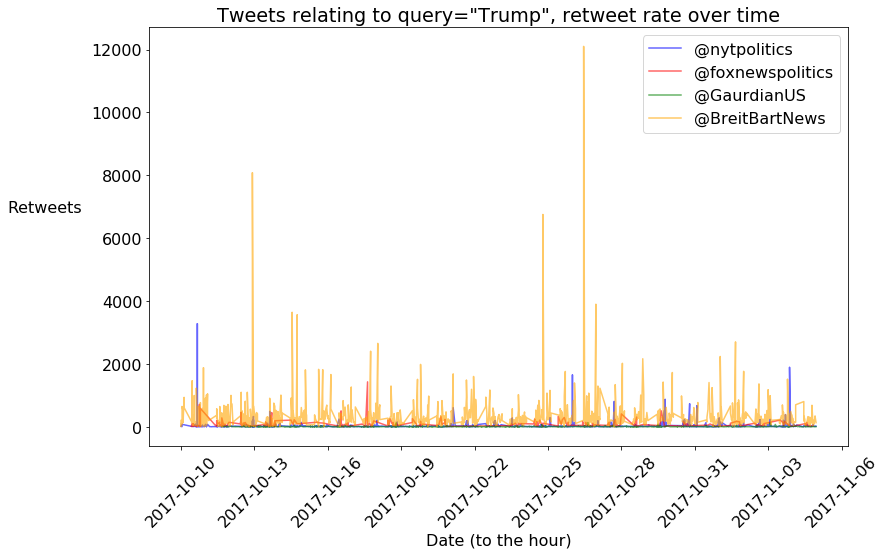

In [141]:
#lets try to plot some other things:
#How about retweets over time?
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))

#define variables to plot:
x_ny = np.array([time for text,time,re,url in nyt if time > datetime(2017, 10, 9, 23, 0) 
                 and time <= datetime(2017, 11, 4, 23, 0)])
y_ny = np.array([re for text,time,re,url in nyt if time > datetime(2017, 10, 9, 23, 0) 
                 and time <= datetime(2017, 11, 4, 23, 0)])

x_g = np.array([time for text,time,re,url in gaurd if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 11, 4, 23, 0)])
y_g = np.array([re for text,time,re,url in gaurd if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 11, 4, 23, 0)])

x_f = np.array([time for text,time,re,url in fox if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 11, 4, 23, 0)])
y_f = np.array([re for text,time,re,url in fox if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 11, 4, 23, 0)])

x_b = np.array([time for text,time,re,url in breit if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 11, 4, 23, 0)])
y_b = np.array([re for text,time,re,url in breit if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 11, 4, 23, 0)])

#Plot the X and Y data for both candidates:
ax.plot(x_ny,y_ny, color = 'blue', label = '@nytpolitics',alpha=0.6)
ax.plot(x_f,y_f, color = 'red', label = '@foxnewspolitics',alpha=0.6)
ax.plot(x_g,y_g, color = 'green', label = '@GaurdianUS',alpha=0.6)
ax.plot(x_b,y_b, color = 'orange', label = '@BreitBartNews',alpha=0.6)

#Make the plot look decent:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#ax.set_yscale("log")
ax.set_ylabel('Retweets',rotation = 'horizontal')
ax.set_xlabel('Date (to the hour)')
plt.xticks(rotation=45)
ax.set_title('Tweets relating to query="Trump", retweet rate over time')
plt.tight_layout()
ax.yaxis.set_label_coords(-0.15,0.55)

plt.show()

#save as png:
fig.savefig('Tweets_Of_News_2017_10_10_to_2017_11_06.png')


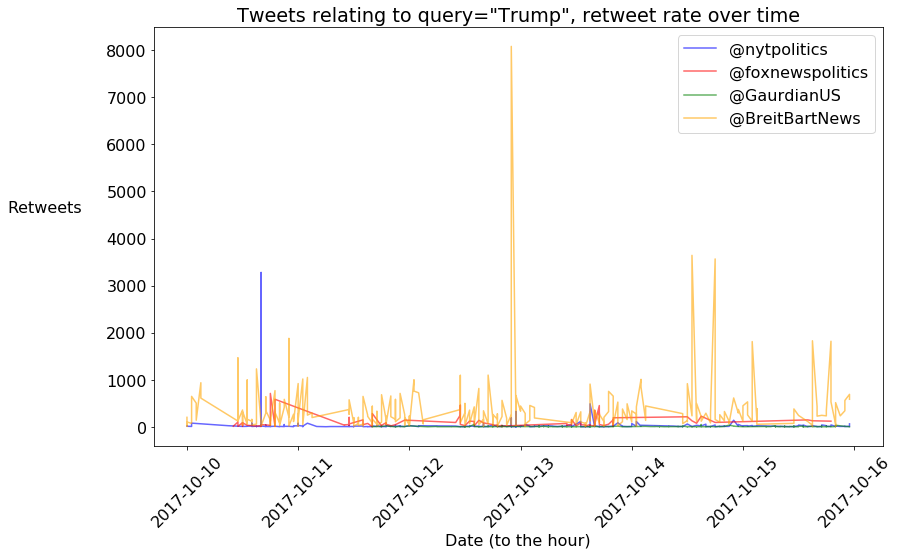

In [142]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))

#define variables to plot:
x_ny = np.array([time for text,time,re,url in nyt if time > datetime(2017, 10, 9, 23, 0) 
                 and time <= datetime(2017, 10, 15, 23, 0)])
y_ny = np.array([re for text,time,re,url in nyt if time > datetime(2017, 10, 9, 23, 0) 
                 and time <= datetime(2017, 10, 15, 23, 0)])

x_g = np.array([time for text,time,re,url in gaurd if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 10, 15, 23, 0)])
y_g = np.array([re for text,time,re,url in gaurd if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 10, 15, 23, 0)])

x_f = np.array([time for text,time,re,url in fox if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 10, 15, 23, 0)])
y_f = np.array([re for text,time,re,url in fox if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 10, 15, 23, 0)])

x_b = np.array([time for text,time,re,url in breit if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 10, 15, 23, 0)])
y_b = np.array([re for text,time,re,url in breit if time > datetime(2017, 10, 9, 23, 0) 
                and time <= datetime(2017, 10, 15, 23, 0)])

#Plot the X and Y data for both candidates:
ax.plot(x_ny,y_ny, color = 'blue', label = '@nytpolitics',alpha=0.6)
ax.plot(x_f,y_f, color = 'red', label = '@foxnewspolitics',alpha=0.6)
ax.plot(x_g,y_g, color = 'green', label = '@GaurdianUS',alpha=0.6)
ax.plot(x_b,y_b, color = 'orange', label = '@BreitBartNews',alpha=0.6)

#Make the plot look decent:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#ax.set_yscale("log")
ax.set_ylabel('Retweets',rotation = 'horizontal')
ax.set_xlabel('Date (to the hour)')
plt.xticks(rotation=45)
ax.set_title('Tweets relating to query="Trump", retweet rate over time')
plt.tight_layout()
ax.yaxis.set_label_coords(-0.15,0.55)

plt.show()

#save as png:
fig.savefig('Tweets_Of_News_2017_10_10_to_2017_10_15.png')



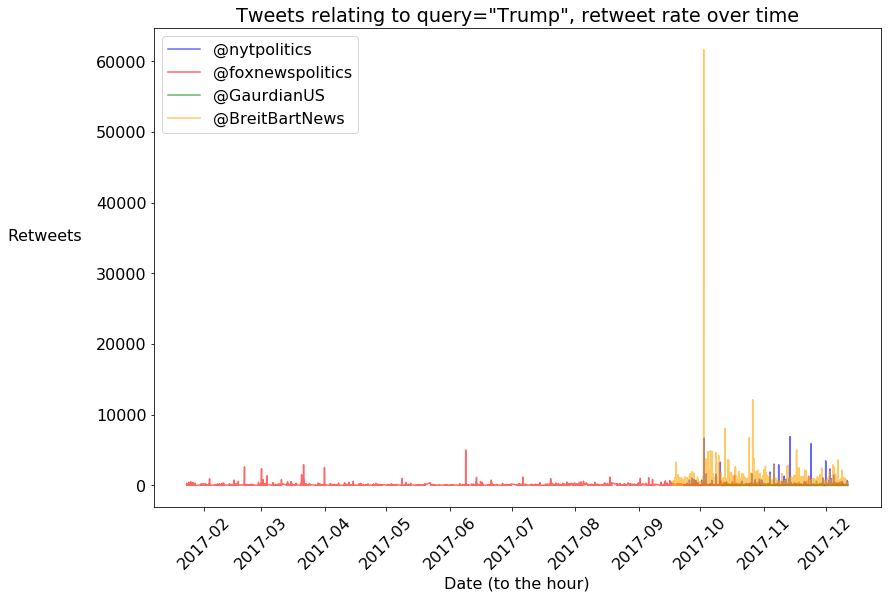

In [143]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))

#define variables to plot:
x_ny = np.array([time for text,time,re,url in nyt])
y_ny = np.array([re for text,time,re,url in nyt])

x_g = np.array([time for text,time,re,url in gaurd])
y_g = np.array([re for text,time,re,url in gaurd])

x_f = np.array([time for text,time,re,url in fox])
y_f = np.array([re for text,time,re,url in fox])

x_b = np.array([time for text,time,re,url in breit])
y_b = np.array([re for text,time,re,url in breit])
#Plot the X and Y data for both candidates:
ax.plot(x_ny,y_ny, color = 'blue', label = '@nytpolitics',alpha=0.6)
ax.plot(x_f,y_f, color = 'red', label = '@foxnewspolitics',alpha=0.6)
ax.plot(x_g,y_g, color = 'green', label = '@GaurdianUS',alpha=0.6)
ax.plot(x_b,y_b, color = 'orange', label = '@BreitBartNews',alpha=0.6)

#Make the plot look decent:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_ylabel('Retweets',rotation = 'horizontal')
ax.set_xlabel('Date (to the hour)')
ax.set_title('Tweets relating to query="Trump", retweet rate over time')
plt.tight_layout()
plt.xticks(rotation = 45)
ax.yaxis.set_label_coords(-0.15,0.55)

plt.show()

#save as png:
fig.savefig('Tweets_Of_News.png')

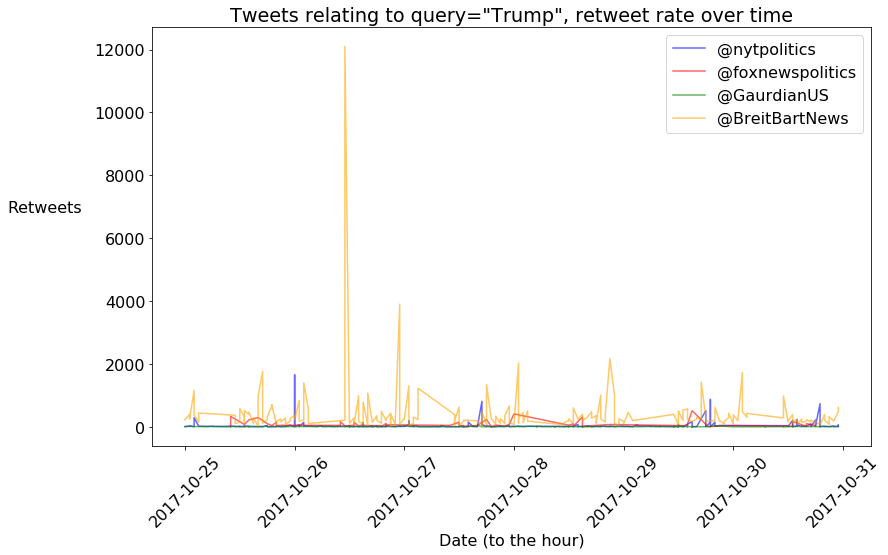

In [144]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))

#define variables to plot:
x_ny = np.array([time for text,time,re,url in nyt if time > datetime(2017, 10, 24, 23, 0) 
                 and time <= datetime(2017, 10, 30, 23, 0)])
y_ny = np.array([re for text,time,re,url in nyt if time > datetime(2017, 10, 24, 23, 0) 
                 and time <=datetime(2017, 10, 30, 23, 0)])

x_g = np.array([time for text,time,re,url in gaurd if time > datetime(2017, 10, 24, 23, 0) 
                and time <= datetime(2017, 10, 30, 23, 0)])
y_g = np.array([re for text,time,re,url in gaurd if time > datetime(2017, 10, 24, 23, 0) 
                and time <= datetime(2017, 10, 30, 23, 0)])

x_f = np.array([time for text,time,re,url in fox if time > datetime(2017, 10, 24, 23, 0) 
                and time <= datetime(2017, 10, 30, 23, 0)])
y_f = np.array([re for text,time,re,url in fox if time > datetime(2017, 10, 24, 23, 0) 
                and time <= datetime(2017, 10, 30, 23, 0)])

x_b = np.array([time for text,time,re,url in breit if time > datetime(2017, 10, 24, 23, 0) 
                and time <= datetime(2017, 10, 30, 23, 0)])
y_b = np.array([re for text,time,re,url in breit if time > datetime(2017, 10, 24, 23, 0) 
                and time <= datetime(2017, 10, 30, 23, 0)])

#Plot the X and Y data for both candidates:
ax.plot(x_ny,y_ny, color = 'blue', label = '@nytpolitics',alpha=0.6)
ax.plot(x_f,y_f, color = 'red', label = '@foxnewspolitics',alpha=0.6)
ax.plot(x_g,y_g, color = 'green', label = '@GaurdianUS',alpha=0.6)
ax.plot(x_b,y_b, color = 'orange', label = '@BreitBartNews',alpha=0.6)

#Make the plot look decent:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#ax.set_yscale("log")
ax.set_ylabel('Retweets',rotation = 'horizontal')
ax.set_xlabel('Date (to the hour)')
plt.xticks(rotation=45)
ax.set_title('Tweets relating to query="Trump", retweet rate over time')
plt.tight_layout()
ax.yaxis.set_label_coords(-0.15,0.55)

plt.show()

#save as png:
fig.savefig('Tweets_Of_News_2017_10_24_to_2017_10_28.png')

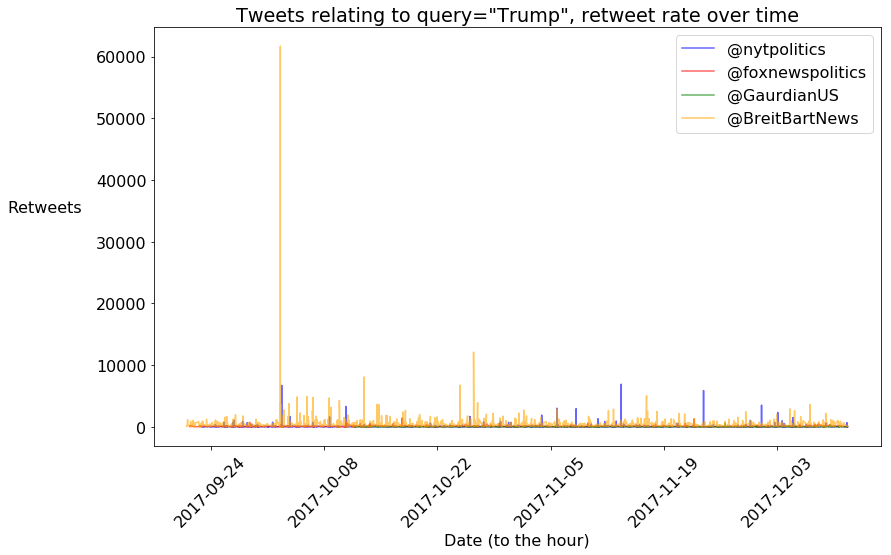

In [145]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))

#define variables to plot:
x_ny = np.array([time for text,time,re,url in nyt if time > datetime(2017, 9, 20, 23, 0)])
y_ny = np.array([re for text,time,re,url in nyt if time > datetime(2017, 9, 20, 23, 0)])

x_g = np.array([time for text,time,re,url in gaurd if time > datetime(2017, 9, 20, 23, 0)])
y_g = np.array([re for text,time,re,url in gaurd if time > datetime(2017, 9, 20, 23, 0)])

x_f = np.array([time for text,time,re,url in fox if time > datetime(2017, 9, 20, 23, 0)])
y_f = np.array([re for text,time,re,url in fox if time > datetime(2017, 9, 20, 23, 0)])

x_b = np.array([time for text,time,re,url in breit if time > datetime(2017, 9, 20, 23, 0)])
y_b = np.array([re for text,time,re,url in breit if time > datetime(2017, 9, 20, 23, 0)])

#Plot the X and Y data for both candidates:
ax.plot(x_ny,y_ny, color = 'blue', label = '@nytpolitics',alpha=0.6)
ax.plot(x_f,y_f, color = 'red', label = '@foxnewspolitics',alpha=0.6)
ax.plot(x_g,y_g, color = 'green', label = '@GaurdianUS',alpha=0.6)
ax.plot(x_b,y_b, color = 'orange', label = '@BreitBartNews',alpha=0.6)

#Make the plot look decent:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#ax.set_yscale("log")
ax.set_ylabel('Retweets',rotation = 'horizontal')
ax.set_xlabel('Date (to the hour)')
plt.xticks(rotation=45)
ax.set_title('Tweets relating to query="Trump", retweet rate over time')
plt.tight_layout()
ax.yaxis.set_label_coords(-0.15,0.55)

plt.show()

#save as png:
fig.savefig('Tweets_Of_News_2017_09_20.png')

# Let's Create a Word Cloud:

In [174]:
ny = [text for text,time,re,url in nyt]
#nyt_cloud = WordCloud.generate()

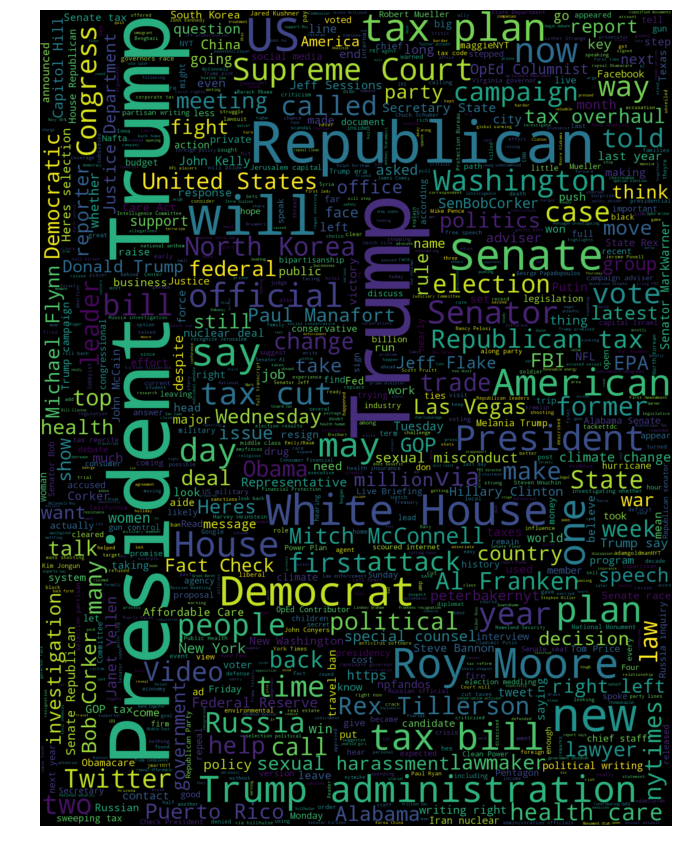

In [178]:
from PIL import Image
from wordcloud import STOPWORDS
ny_times_map = np.array(Image.open("nyt-t-logo.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

ny = ''.join(ny)
nyt_cloud = WordCloud(background_color="black",mask=ny_times_map,max_words=1000, stopwords=stopwords).generate(ny)

#generate cloud:
plt.figure(figsize=(15,15))
plt.imshow(nyt_cloud, interpolation='bilinear' ,cmap='viridis')
plt.axis("off")

#save as png:
fig.savefig('ny_times_wordcloud.png')

(-0.5, 224.5, 224.5, -0.5)

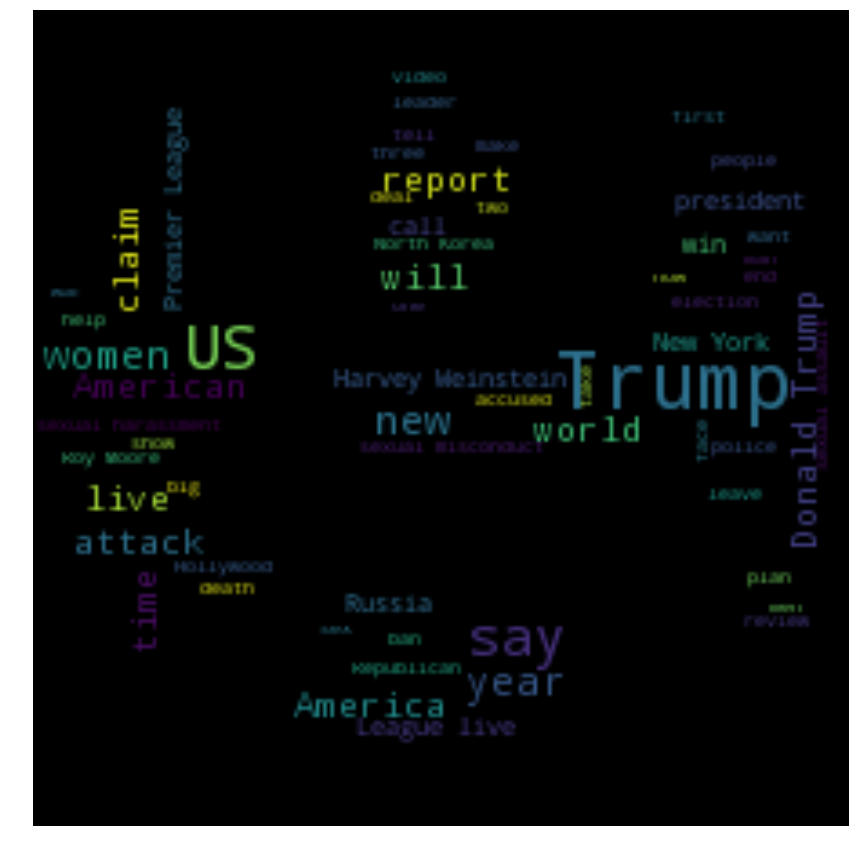

In [187]:
gaurd_w = [text for text,time,re,url in gaurd]
ga = ''.join(gaurd_w)
g_map = np.array(Image.open("guardian.jpg"))
gaurd_cloud = WordCloud(background_color="black",max_words=2000,mask=g_map, stopwords=stopwords).generate(ga)
#generate cloud:
plt.figure(figsize=(15,15))
plt.imshow(gaurd_cloud, interpolation='bilinear' ,cmap='viridis')
plt.axis("off")


(-0.5, 274.5, 182.5, -0.5)

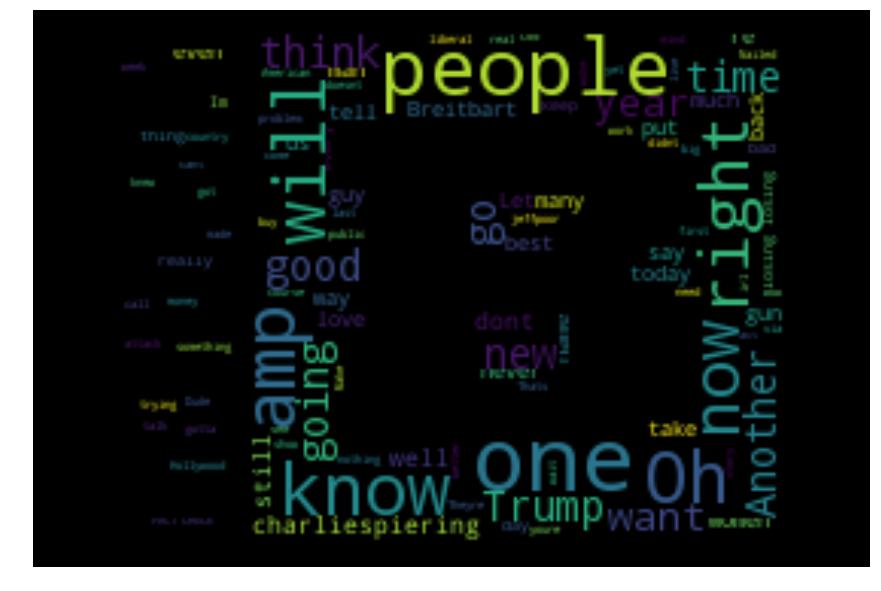

In [188]:
breit_bart_words = [text for text,time,re,url in breit]
br = ''.join(breit_bart_words)

#generate cloud:
b_map = np.array(Image.open("breit.jpg"))
breit_cloud = WordCloud(background_color="black",max_words=2000,mask=b_map, stopwords=stopwords).generate(br)

plt.figure(figsize=(15,15))
plt.imshow(breit_cloud, interpolation='bilinear' ,cmap='viridis')
plt.axis("off")


(-0.5, 1199.5, 1130.5, -0.5)

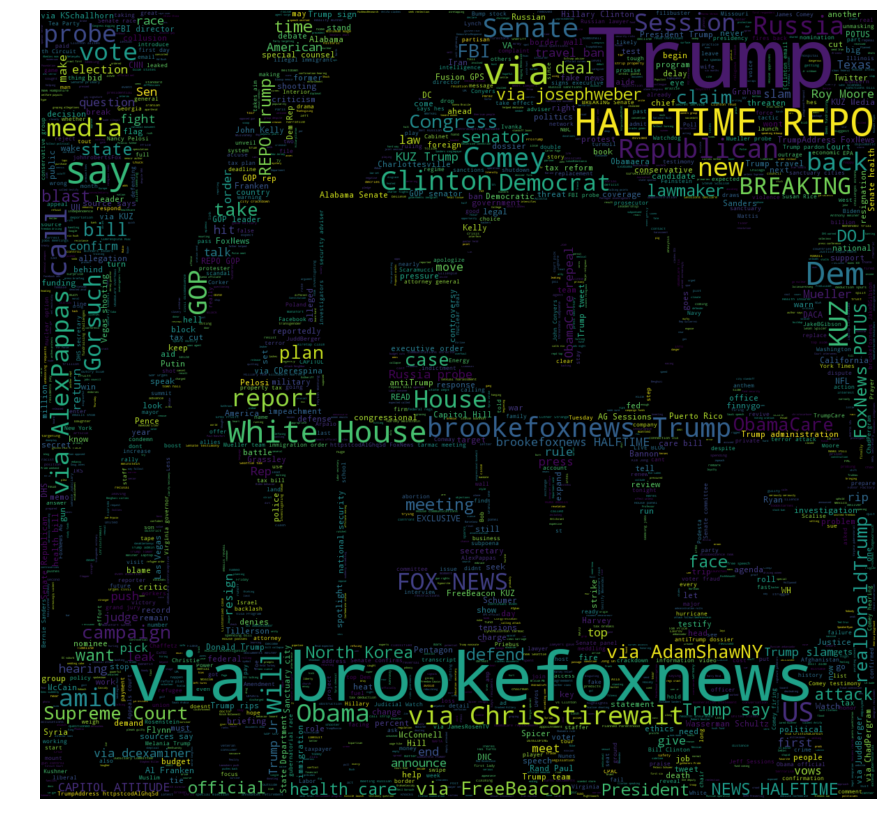

In [189]:
f_news = [text for text,time,re,url in fox]
fn = ''.join(f_news)

#generate cloud:
f_map = np.array(Image.open("1200px-Fox_News_Channel_logo.svg.png"))
fox_cloud = WordCloud(background_color='black',mask=f_map,max_words=2000,stopwords=stopwords).generate(fn)

plt.figure(figsize=(15,15))
plt.imshow(fox_cloud, interpolation='bilinear' ,cmap='viridis')
plt.axis("off")
